<a href="https://colab.research.google.com/github/kMirzaev/twitter_sent_analysis/blob/main/Sentiment140Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#installs & imports

In [ ]:
!pip install wget
!pip install utils
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz
!pip install wordcloud
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import wget
import zipfile
from transformers import BertTokenizer,BertForSequenceClassification,AdamW
import re 
from string import punctuation
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split
import random
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer,BertForSequenceClassification
import torch
from tqdm.notebook import tqdm
import tensorflow as tf
%matplotlib inline
sns.set(color_codes=True)

##Checking the available hardware accelerator

In [56]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


#Downloading and preproccesing the dataset from [stanford](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip)
The sentiment140 dataset contains 1.6 million tweets categorized 4 for positive or 0 for negative

In [4]:
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

# Download the file (if we haven't already)
if not os.path.exists('./trainingandtestdata.zip'):
    wget.download(url, './trainingandtestdata.zip')

with zipfile.ZipFile("/content/trainingandtestdata.zip","r") as zip_ref:
    zip_ref.extractall("/content")

## Setting the headers, and droping unnecessary columns, keeping only Sentiment(rating) and Tweet(text)

In [5]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [6]:
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


##Reducing the size of the dataset for faster training

Uncomment for faster training

In [7]:
#sample_size = int(len(df)*0.5)
#df = df.sample(sample_size, random_state=23)

##Checking how equally are the tweets distributed
Is equally distributed 50%-50% for positive and negative

In [34]:
print('Negative samples: %d of %d (%.2f%%)' % (sum(df.Sentiment.eq(0)), len(df.Sentiment), (sum(df.Sentiment.eq(0)) / len(df.Sentiment) * 100.0)))

Negative samples: 800000 of 1600000 (50.00%)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


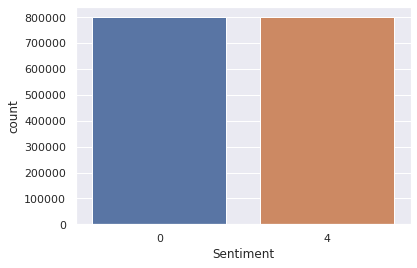

In [35]:
sns.countplot(df.Sentiment)

## Replacing the rating score 4 with 1 

In [36]:
df['Sentiment'] = df.Sentiment.replace(4,1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


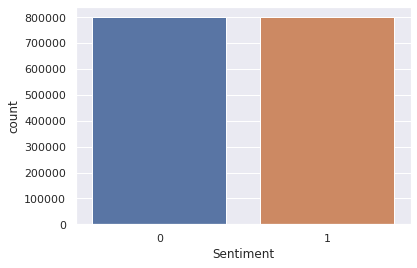

In [37]:
sns.countplot(df.Sentiment)

## Helper function to clean tweets

In [38]:
def processTweet(tweet):
    # convert @username to AT_USER
    tweet = re.sub('@[^\s]+','entity',tweet)
    # remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;','', tweet)
    # remove tickers
    tweet = re.sub(r'\$\w','',tweet)
    # convert tweet to lowercase
    tweet = tweet.lower()
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*','hashtag',tweet)
    # remove hashtags
    tweet = re.sub(r'#\w*','',tweet)
    # remove punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'['+ punctuation.replace('@', '') +']+', ' ', tweet)
    # remove words with two or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b','', tweet)
    # remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')     

    return tweet

In [39]:
df['Tweet'] = df.Tweet.apply(processTweet)

In [40]:
df.head()

,Sentiment,Tweet
0,0,entity hashtag awww that bummer you shoulda go...
1,0,upset that can update his facebook texting and...
2,0,entity dived many times for the ball managed s...
3,0,whole body feels itchy and like its fire
4,0,entity not behaving all mad why here because c...


In [41]:
labels = df.Sentiment.values
text = df.Tweet.values

##Finding mean length of a tweet

In [42]:
print(df.Tweet.map(lambda x: len(x)).mean())

57.527076875


#Downloading and applying BertTokenizer

In [43]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [44]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=80,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


##Preview tokenized tweet


In [45]:
# Print the original sentence.
print(' Original: ', df.Tweet[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Tweet[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Tweet[0])))

 Original:  entity hashtag awww that bummer you shoulda got david carr third day 
Tokenized:  ['entity', 'hash', '##tag', 'aw', '##w', '##w', 'that', 'bum', '##mer', 'you', 'should', '##a', 'got', 'david', 'carr', 'third', 'day']
Token IDs:  [9178, 23325, 15900, 22091, 2860, 2860, 2008, 26352, 5017, 2017, 2323, 2050, 2288, 2585, 12385, 2353, 2154]


#Spliting The dataset to train and validation

In [46]:
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  1280000
Validation Size -  320000


#We’ll also create an iterator for our dataset using the torch DataLoader class.

In [47]:
batch_size = 16
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = batch_size)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = batch_size)

#We’ll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier.

In [48]:
model = BertForSequenceClassification.from_pretrained(
'bert-base-uncased',
num_labels = 2,
output_attentions = False,
output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [49]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# AdamW optimizer used with lr 1e-5

In [50]:
optimizer = AdamW(model.parameters(),lr = 1e-5)

#Setting the variables and the functions for the training

In [51]:
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [52]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [53]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dl)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')


#Saving the model and the tokenizer

In [ ]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

#Function to test the model

In [ ]:
def Sentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
        
    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [ ]:
ans = Sentiment('i do not feel well')

In [ ]:
if ans == 1:
    print("Positive")
else:
    print("Negative")